In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset

# Verificar si hay GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Función para preprocesar texto
def preprocess_text(text_series):
    text_series = text_series.str.replace(r'http\S+', '', regex=True)  # Eliminar URLs
    text_series = text_series.str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)  # Eliminar caracteres especiales
    return text_series.str.lower().str.strip()

# Cargar datasets
train_data = pd.read_csv("divisonDatos/train_data.csv", sep=";")
val_data = pd.read_csv("divisonDatos/val_data.csv", sep=";")
test_data = pd.read_csv("divisonDatos/test_data.csv", sep=";")

Usando dispositivo: cuda


Epoch 0/2000, Loss: 0.6923, Val Loss: 0.6918
Epoch 10/2000, Loss: 0.6821, Val Loss: 0.6832
Epoch 20/2000, Loss: 0.6725, Val Loss: 0.6750
Epoch 30/2000, Loss: 0.6634, Val Loss: 0.6674
Epoch 40/2000, Loss: 0.6547, Val Loss: 0.6601
Epoch 50/2000, Loss: 0.6464, Val Loss: 0.6532
Epoch 60/2000, Loss: 0.6386, Val Loss: 0.6466
Epoch 70/2000, Loss: 0.6309, Val Loss: 0.6403
Epoch 80/2000, Loss: 0.6235, Val Loss: 0.6344
Epoch 90/2000, Loss: 0.6166, Val Loss: 0.6286
Epoch 100/2000, Loss: 0.6099, Val Loss: 0.6232
Epoch 110/2000, Loss: 0.6035, Val Loss: 0.6179
Epoch 120/2000, Loss: 0.5973, Val Loss: 0.6129
Epoch 130/2000, Loss: 0.5915, Val Loss: 0.6082
Epoch 140/2000, Loss: 0.5855, Val Loss: 0.6036
Epoch 150/2000, Loss: 0.5802, Val Loss: 0.5993
Epoch 160/2000, Loss: 0.5749, Val Loss: 0.5951
Epoch 170/2000, Loss: 0.5697, Val Loss: 0.5911
Epoch 180/2000, Loss: 0.5647, Val Loss: 0.5873
Epoch 190/2000, Loss: 0.5600, Val Loss: 0.5837
Epoch 200/2000, Loss: 0.5556, Val Loss: 0.5802
Epoch 210/2000, Loss: 0.

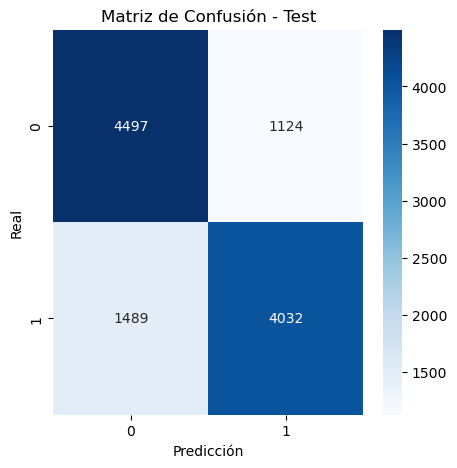

In [3]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesar texto
train_data['Texto'] = preprocess_text(train_data['Texto'])
val_data['Texto'] = preprocess_text(val_data['Texto'])
test_data['Texto'] = preprocess_text(test_data['Texto'])

# Convertir texto a vectores numéricos usando TF-IDF
vectorizer = TfidfVectorizer(max_features=20000)
X_train = vectorizer.fit_transform(train_data['Texto']).toarray()
X_val = vectorizer.transform(val_data['Texto']).toarray()
X_test = vectorizer.transform(test_data['Texto']).toarray()

y_train = train_data['Label'].values
y_val = val_data['Label'].values
y_test = test_data['Label'].values

# Calcular pesos de clase
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# Crear DataLoader
batch_size = 256
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Modelo de regresión logística
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.fc(x))

# Inicializar modelo
input_dim = X_train.shape[1]
model = LogisticRegressionModel(input_dim).to(device)

# Inicializar pesos del modelo
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(init_weights)

# Definir función de pérdida (sin reducción para aplicar pesos)
criterion = nn.BCELoss(reduction='none')  

############################################################
# Implementación MANUAL de RMSProp 
############################################################
class ManualRMSProp:
    """
    Implementación manual de RMSProp sin usar librerías de optimización.
    """
    def __init__(self, params, lr=1e-4, alpha=0.99, eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.state = {}
        for p in self.params:
            # Almacena el promedio móvil de los gradientes al cuadrado
            self.state[p] = torch.zeros_like(p, memory_format=torch.preserve_format)

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

    def step(self):
        for p in self.params:
            if p.grad is None:
                continue
            grad = p.grad.data
            # Actualiza el promedio móvil de gradientes^2
            self.state[p].mul_(self.alpha).addcmul_(grad, grad, value=1 - self.alpha)
            # Actualiza el parámetro
            denom = self.state[p].sqrt().add_(self.eps)
            p.data.addcdiv_(grad, denom, value=-self.lr)

# Usar nuestro optimizador manual RMSProp en lugar de optim.RMSprop
optimizer = ManualRMSProp(model.parameters(), lr=0.00005, alpha=0.99, eps=1e-8)

# Early stopping ajustado
class EarlyStopping:
    def __init__(self, patience=30, delta=0):  # Aumentar paciencia si se desea
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.stop_training = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_training = True
        return self.stop_training

# Entrenar modelo
def train_model(model, train_loader, criterion, optimizer, val_loader, class_weights, n_epochs=2000):
    early_stopping = EarlyStopping(patience=20, delta=0.0001)
    model.train()

    for epoch in range(n_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            labels = labels.view(-1, 1)
            loss = criterion(outputs, labels)

            # Aplicar pesos a la pérdida
            weights = torch.where(labels == 1, class_weights[1], class_weights[0])
            loss = (loss * weights).mean()

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validación
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.view(-1, 1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                weights = torch.where(labels == 1, class_weights[1], class_weights[0])
                val_loss += (loss * weights).mean().item()

        if early_stopping(val_loss / len(val_loader)):
            print(f"Early stopping en la época {epoch}")
            break

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{n_epochs}, Loss: {running_loss / len(train_loader):.4f}, "
                  f"Val Loss: {val_loss / len(val_loader):.4f}")
        model.train()

# Entrenar modelo
train_model(model, train_loader, criterion, optimizer, val_loader, class_weights, n_epochs=2000)

# Evaluar modelo
def evaluate_model(model, data_loader, threshold=0.5):
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = (outputs >= threshold).float()
            y_pred.extend(predictions.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    y_pred = np.array(y_pred).flatten()
    y_true = np.array(y_true).flatten()

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    return acc, f1, precision, recall

# Ajustar umbral dinámicamente
thresholds = np.linspace(0.1, 0.9, 100)
best_metrics = None
for threshold in thresholds:
    acc, f1, precision, recall = evaluate_model(model, val_loader, threshold=threshold)
    if 0.79 <= precision <= 0.80:
        best_metrics = (threshold, acc, f1, precision, recall)
        break

if best_metrics:
    threshold, acc, f1, precision, recall = best_metrics
    print(f"Mejor umbral: {threshold:.2f}")
    print(f"Evaluación en validación: Acc: {acc:.4f}, F1: {f1:.4f}, Precisión: {precision:.4f}, Recall: {recall:.4f}")
else:
    # Por si no encontramos un threshold en ese rango de precisión
    threshold = 0.5  # Por defecto
    acc, f1, precision, recall = evaluate_model(model, val_loader, threshold=threshold)
    print(f"Umbral por defecto (0.5). Evaluación en validación: Acc: {acc:.4f}, F1: {f1:.4f}, "
          f"Precisión: {precision:.4f}, Recall: {recall:.4f}")

# Evaluar en test
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)
acc, f1, precision, recall = evaluate_model(model, test_loader, threshold=threshold)
print(f"Evaluación en test: Acc: {acc:.4f}, F1: {f1:.4f}, Precisión: {precision:.4f}, Recall: {recall:.4f}")

############################################################
# Matriz de confusión en gráfica
############################################################
# Obtenemos nuevamente las predicciones finales del test
model.eval()
y_pred_test, y_true_test = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions = (outputs >= threshold).float()
        y_pred_test.extend(predictions.cpu().numpy())
        y_true_test.extend(labels.cpu().numpy())

y_pred_test = np.array(y_pred_test).flatten()
y_true_test = np.array(y_true_test).flatten()

cm = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Test")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()
